In [1]:
import gensim
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, MultiHeadAttention, Dropout, LayerNormalization, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model


In [2]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
class_counts = train_data.groupby('class').size()
print(class_counts)

class
갈취 대화           981
기타 괴롭힘 대화      1094
직장 내 괴롭힘 대화     979
협박 대화           896
dtype: int64


In [4]:
label_to_int = {'협박 대화': 0, '갈취 대화': 1, '직장 내 괴롭힘 대화': 2, '기타 괴롭힘 대화':3}

train_data['class'] = train_data['class'].map(label_to_int)

In [5]:
train_data.head()

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [6]:
int_to_label = {0: '협박 대화', 1: '갈취 대화', 2: '직장 내 괴롭힘 대화', 3: '기타 괴롭힘 대화'}

In [7]:
# train da를 x,y로 분류

x = train_data['conversation']
y = train_data['class']

In [8]:
# Colab에서 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [11]:
print('데이터 정보')
print('-'*50)
print('x :',x.shape)
print('y :',y.shape)
print('label 종류:', int_to_label)
print('-'*50)
num_classes = 4
print('클래스의 수 : {}'.format(num_classes))
print('-'*50)
print('훈련용 데이터의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 데이터의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of sample lengths
axes[0].hist([len(s) for s in x_train], bins=50)
axes[0].set_xlabel('length of samples')
axes[0].set_ylabel('number of samples')
axes[0].set_title('Sample Length Distribution')

# Plot the count of each class
sns.countplot(x=y_train, ax=axes[1])
axes[1].set_title('Class Distribution')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

데이터 정보
--------------------------------------------------
x : (3950,)
y : (3950,)
label 종류: {0: '협박 대화', 1: '갈취 대화', 2: '직장 내 괴롭힘 대화', 3: '기타 괴롭힘 대화'}
--------------------------------------------------
클래스의 수 : 4
--------------------------------------------------


NameError: name 'x_train' is not defined

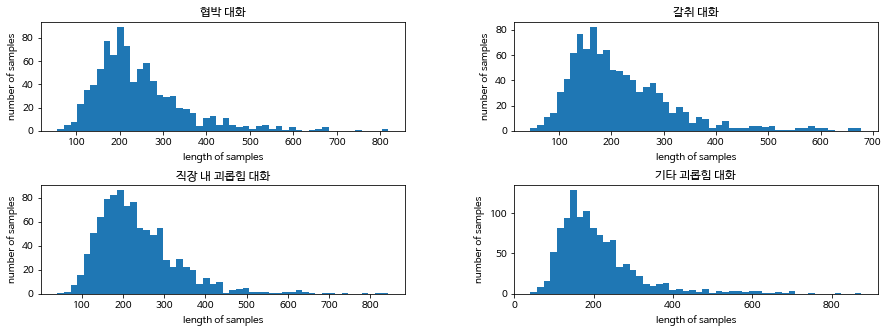

In [12]:
#데이터 클래스별 길이 분포 확인

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

# Plot the histogram of sample lengths
axes[0][0].hist([len(s) for s in train_data['conversation'][train_data['class']==0]], bins=50)
axes[0][0].set_xlabel('length of samples')
axes[0][0].set_ylabel('number of samples')
axes[0][0].set_title('협박 대화')

axes[0][1].hist([len(s) for s in train_data['conversation'][train_data['class']==1]], bins=50)
axes[0][1].set_xlabel('length of samples')
axes[0][1].set_ylabel('number of samples')
axes[0][1].set_title('갈취 대화')

axes[1][0].hist([len(s) for s in train_data['conversation'][train_data['class']==2]], bins=50)
axes[1][0].set_xlabel('length of samples')
axes[1][0].set_ylabel('number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

axes[1][1].hist([len(s) for s in train_data['conversation'][train_data['class']==3]
], bins=50)
axes[1][1].set_xlabel('length of samples')
axes[1][1].set_ylabel('number of samples')
axes[1][1].set_title('기타 괴롭힘 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [13]:
import re

def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [14]:
from konlpy.tag import Mecab
m = Mecab()

In [15]:
from tqdm import tqdm

corpus = list()
for sentence in tqdm(train_data['conversation']):
    corpus.append(m.morphs(sentence))

100%|██████████| 3950/3950 [00:02<00:00, 1744.23it/s]


Text(0.5, 1.0, 'histogram for sentence length')

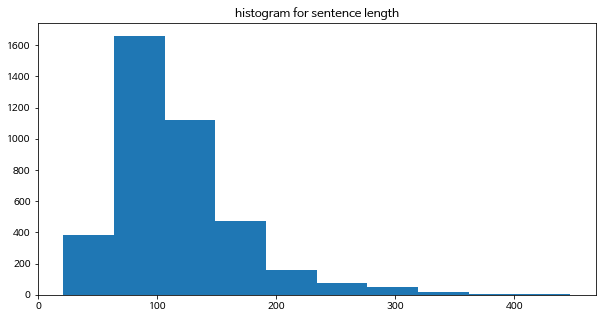

In [16]:
len_list = [len(i) for i in corpus]

plt.figure(figsize=(10,5))
plt.hist(len_list)
plt.title('histogram for sentence length')

In [17]:
len_list_shorter = [len(i) for i in corpus if len(i) <= 200]

print("길이 200 이하인 문장의 비율: ", len(len_list_shorter)/len(len_list)*100)

길이 200 이하인 문장의 비율:  93.39240506329114


In [18]:
# 토큰화 후 정수 인코딩 하는 함수
def tokenize(corpus, max_words=10000, max_len=200):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')

    return tensor

In [19]:
x = tokenize(x)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [21]:
import wandb
from wandb.keras import WandbCallback

In [22]:
wandb.login(key='5a2bb8305d334d4e482ca2556916549545cb92d3')

wandb: Currently logged in as: synkim1129. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [23]:
sweep_config = {
    "name": "sweep_DLthon_LSTM_01",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 20
            }
                    
        }
    }

In [24]:
# 양방향 LSTM 모델

def train_lstm():
    default_config = {
        "vocab_size" : 10000,
        "embedding_dim" : 64,
        "units_1" : 64,
        "units_2" : 64,
        "units_dense" : 64,
        "class_num" : 4,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 10,
        "batch_size" : 32
    }
    
    wandb.init(config = default_config)
    config = wandb.config

    # 모델의 입력 정의
    sequence_input = Input(shape=(None,), dtype='int32')

    # 임베딩 레이어
    embedded_sequences = Embedding(config.vocab_size, config.embedding_dim)(sequence_input)

    # 양방향 LSTM 레이어 2개를 쌓음
    x = Bidirectional(LSTM(config.units_1, return_sequences=True))(embedded_sequences)  # 첫 번째 LSTM
    x = Bidirectional(LSTM(config.units_2))(x)  # 두 번째 LSTM

    # Dense 레이어
    x = Dense(config.units_dense, activation='relu')(x)

    # 출력 레이어: 4개의 클래스에 대한 예측을 출력
    predictions = Dense(config.class_num, activation='softmax')(x)

    # 최종 모델 생성
    model = Model(sequence_input, predictions)
    
    if config.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate = config.learning_rate)

    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(x_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (x_val, y_val),
              callbacks = [WandbCallback()])
    
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [25]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요
sweep_id = wandb.sweep(sweep_config,
                       entity = 'synkim1129',
                       project = 'DLthon')

# run the sweep
wandb.agent(sweep_id,
            function=train_lstm,
            count=16)

Create sweep with ID: 9irgy1d2
Sweep URL: https://wandb.ai/synkim1129/DLthon/sweeps/9irgy1d2


wandb: Agent Starting Run: err4bsy7 with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.09524312563145254


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/8
79/79 [==============================] - 10s 48ms/step - loss: 1.8502 - accuracy: 0.2583 - val_loss: 1.3875 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best)... Done. 0.0s


Epoch 2/8
79/79 [==============================] - 2s 30ms/step - loss: 1.3854 - accuracy: 0.2761 - val_loss: 1.3889 - val_accuracy: 0.2769
Epoch 3/8
79/79 [==============================] - 2s 28ms/step - loss: 1.3910 - accuracy: 0.2646 - val_loss: 1.3851 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best)... Done. 0.0s


Epoch 4/8
79/79 [==============================] - 2s 30ms/step - loss: 1.3873 - accuracy: 0.2623 - val_loss: 1.3882 - val_accuracy: 0.2769
Epoch 5/8
79/79 [==============================] - 2s 28ms/step - loss: 1.3893 - accuracy: 0.2551 - val_loss: 1.4114 - val_accuracy: 0.2263
Epoch 6/8
79/79 [==============================] - 2s 28ms/step - loss: 1.3918 - accuracy: 0.2650 - val_loss: 1.3870 - val_accuracy: 0.2484
Epoch 7/8
79/79 [==============================] - 2s 27ms/step - loss: 1.3950 - accuracy: 0.2547 - val_loss: 1.3845 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073213-err4bsy7/files/model-best)... Done. 0.0s


Epoch 8/8
79/79 [==============================] - 2s 30ms/step - loss: 1.3876 - accuracy: 0.2718 - val_loss: 1.3884 - val_accuracy: 0.2769
25/25 - 0s - loss: 1.3883 - accuracy: 0.2772


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▂█▄▃▁▄▁▇
epoch,▁▂▃▄▅▆▇█
loss,█▁▁▁▁▁▁▁
val_accuracy,██▄█▁▄██
val_loss,▂▂▁▂█▂▁▂
Test Accuracy Rate:,27.72
Test Error Rate:,72.28
accuracy,0.27176
best_epoch,6


wandb: Agent Starting Run: ujjcbf9o with config:
wandb: 	epoch: 18
wandb: 	learning_rate: 0.038443449296689226


Epoch 1/18
79/79 [==============================] - 7s 44ms/step - loss: 1.4668 - accuracy: 0.2714 - val_loss: 1.3472 - val_accuracy: 0.4003


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best)... Done. 0.0s


Epoch 2/18
79/79 [==============================] - 2s 30ms/step - loss: 1.2573 - accuracy: 0.3936 - val_loss: 1.1858 - val_accuracy: 0.3972


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best)... Done. 0.1s


Epoch 3/18
79/79 [==============================] - 2s 30ms/step - loss: 0.9949 - accuracy: 0.5597 - val_loss: 1.0847 - val_accuracy: 0.5269


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best)... Done. 0.1s


Epoch 4/18
79/79 [==============================] - 2s 30ms/step - loss: 0.8280 - accuracy: 0.6598 - val_loss: 1.0634 - val_accuracy: 0.5807


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best)... Done. 0.0s


Epoch 5/18
79/79 [==============================] - 2s 30ms/step - loss: 0.6551 - accuracy: 0.7595 - val_loss: 1.0588 - val_accuracy: 0.6297


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073452-ujjcbf9o/files/model-best)... Done. 0.1s


Epoch 6/18
79/79 [==============================] - 2s 30ms/step - loss: 0.5748 - accuracy: 0.7967 - val_loss: 1.1073 - val_accuracy: 0.6203
Epoch 7/18
79/79 [==============================] - 2s 28ms/step - loss: 0.5433 - accuracy: 0.8101 - val_loss: 1.1251 - val_accuracy: 0.6266
Epoch 8/18
79/79 [==============================] - 2s 28ms/step - loss: 0.4626 - accuracy: 0.8350 - val_loss: 1.2767 - val_accuracy: 0.6108
Epoch 9/18
79/79 [==============================] - 2s 27ms/step - loss: 0.4262 - accuracy: 0.8560 - val_loss: 1.2043 - val_accuracy: 0.6203
Epoch 10/18
79/79 [==============================] - 2s 28ms/step - loss: 0.3760 - accuracy: 0.8683 - val_loss: 1.1310 - val_accuracy: 0.6598
Epoch 11/18
79/79 [==============================] - 2s 28ms/step - loss: 0.4299 - accuracy: 0.8493 - val_loss: 1.1954 - val_accuracy: 0.6123
Epoch 12/18
79/79 [==============================] - 2s 28ms/step - loss: 0.3844 - accuracy: 0.8671 - val_loss: 1.2345 - val_accuracy: 0.6361
Epoch 13/1

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▂▄▅▆▇▇▇▇█▇███████
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▇▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▄▆▇▇▇▇▇█▇▇▇▇▇▇▇▇
val_loss,█▄▂▁▁▂▃▆▅▃▄▅▃▅▇██▃
Test Accuracy Rate:,60.76
Test Error Rate:,39.24
accuracy,0.8928
best_epoch,4


wandb: Agent Starting Run: be0yqu56 with config:
wandb: 	epoch: 13
wandb: 	learning_rate: 0.0865780036876366


Epoch 1/13
79/79 [==============================] - 9s 67ms/step - loss: 1.7130 - accuracy: 0.2603 - val_loss: 1.3876 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best)... Done. 0.0s


Epoch 2/13
79/79 [==============================] - 2s 30ms/step - loss: 1.3866 - accuracy: 0.2761 - val_loss: 1.3865 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best)... Done. 0.0s


Epoch 3/13
79/79 [==============================] - 2s 30ms/step - loss: 1.3907 - accuracy: 0.2686 - val_loss: 1.3861 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best)... Done. 0.0s


Epoch 4/13
79/79 [==============================] - 2s 30ms/step - loss: 1.3885 - accuracy: 0.2654 - val_loss: 1.4003 - val_accuracy: 0.2484
Epoch 5/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3910 - accuracy: 0.2725 - val_loss: 1.3987 - val_accuracy: 0.2484
Epoch 6/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3911 - accuracy: 0.2702 - val_loss: 1.3882 - val_accuracy: 0.2484
Epoch 7/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3913 - accuracy: 0.2544 - val_loss: 1.3874 - val_accuracy: 0.2484
Epoch 8/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3894 - accuracy: 0.2725 - val_loss: 1.3970 - val_accuracy: 0.2484
Epoch 9/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3909 - accuracy: 0.2520 - val_loss: 1.3870 - val_accuracy: 0.2484
Epoch 10/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3903 - accuracy: 0.2666 - val_loss: 1.3840 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_073828-be0yqu56/files/model-best)... Done. 0.0s


Epoch 11/13
79/79 [==============================] - 2s 30ms/step - loss: 1.3883 - accuracy: 0.2741 - val_loss: 1.3887 - val_accuracy: 0.2484
Epoch 12/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3910 - accuracy: 0.2512 - val_loss: 1.3854 - val_accuracy: 0.2769
Epoch 13/13
79/79 [==============================] - 2s 28ms/step - loss: 1.3878 - accuracy: 0.2579 - val_loss: 1.3888 - val_accuracy: 0.2769
25/25 - 0s - loss: 1.3887 - accuracy: 0.2772


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▄█▆▅▇▆▂▇▁▅▇▁▃
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁█▁▁▁▁▁▁█▁██
val_loss,▃▂▂█▇▃▂▇▂▁▃▂▃
Test Accuracy Rate:,27.72
Test Error Rate:,72.28
accuracy,0.25791
best_epoch,9


wandb: Agent Starting Run: v7jp17sn with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 0.045746960131023584


Epoch 1/15
79/79 [==============================] - 9s 43ms/step - loss: 1.4475 - accuracy: 0.2623 - val_loss: 1.3851 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best)... Done. 0.0s


Epoch 2/15
79/79 [==============================] - 2s 30ms/step - loss: 1.3864 - accuracy: 0.2710 - val_loss: 1.3851 - val_accuracy: 0.2769
Epoch 3/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3884 - accuracy: 0.2694 - val_loss: 1.3858 - val_accuracy: 0.2769
Epoch 4/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3880 - accuracy: 0.2769 - val_loss: 1.3876 - val_accuracy: 0.2484
Epoch 5/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3877 - accuracy: 0.2674 - val_loss: 1.3848 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best)... Done. 0.0s


Epoch 6/15
79/79 [==============================] - 2s 30ms/step - loss: 1.3868 - accuracy: 0.2781 - val_loss: 1.3854 - val_accuracy: 0.2484
Epoch 7/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3878 - accuracy: 0.2544 - val_loss: 1.3840 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074035-v7jp17sn/files/model-best)... Done. 0.0s


Epoch 8/15
79/79 [==============================] - 2s 30ms/step - loss: 1.3888 - accuracy: 0.2508 - val_loss: 1.3850 - val_accuracy: 0.2769
Epoch 9/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3876 - accuracy: 0.2702 - val_loss: 1.3896 - val_accuracy: 0.2484
Epoch 10/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3880 - accuracy: 0.2611 - val_loss: 1.3846 - val_accuracy: 0.2769
Epoch 11/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3875 - accuracy: 0.2607 - val_loss: 1.3880 - val_accuracy: 0.2769
Epoch 12/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3862 - accuracy: 0.2646 - val_loss: 1.3861 - val_accuracy: 0.2769
Epoch 13/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3856 - accuracy: 0.2737 - val_loss: 1.3843 - val_accuracy: 0.2769
Epoch 14/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3879 - accuracy: 0.2682 - val_loss: 1.3852 - val_accuracy: 0.2769
Epoch 15

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▄▆▆█▅█▂▁▆▄▄▅▇▅▆
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,███▁█▁██▁██████
val_loss,▂▂▃▆▂▃▁▂█▂▆▄▁▃▁
Test Accuracy Rate:,27.72
Test Error Rate:,72.28
accuracy,0.27057
best_epoch,6


wandb: Agent Starting Run: tjbdaypx with config:
wandb: 	epoch: 14
wandb: 	learning_rate: 0.07012151808088601


Epoch 1/14
79/79 [==============================] - 7s 44ms/step - loss: 1.5439 - accuracy: 0.2638 - val_loss: 1.3864 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best)... Done. 0.1s


Epoch 2/14
79/79 [==============================] - 2s 30ms/step - loss: 1.3865 - accuracy: 0.2797 - val_loss: 1.3879 - val_accuracy: 0.2484
Epoch 3/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3896 - accuracy: 0.2520 - val_loss: 1.3871 - val_accuracy: 0.2484
Epoch 4/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3881 - accuracy: 0.2646 - val_loss: 1.3870 - val_accuracy: 0.2484
Epoch 5/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3863 - accuracy: 0.2801 - val_loss: 1.3889 - val_accuracy: 0.2263
Epoch 6/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3874 - accuracy: 0.2662 - val_loss: 1.3867 - val_accuracy: 0.2769
Epoch 7/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3889 - accuracy: 0.2615 - val_loss: 1.3849 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best)... Done. 0.1s


Epoch 8/14
79/79 [==============================] - 2s 30ms/step - loss: 1.3885 - accuracy: 0.2607 - val_loss: 1.3915 - val_accuracy: 0.2484
Epoch 9/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3892 - accuracy: 0.2619 - val_loss: 1.3898 - val_accuracy: 0.2484
Epoch 10/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3879 - accuracy: 0.2737 - val_loss: 1.3855 - val_accuracy: 0.2484
Epoch 11/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3888 - accuracy: 0.2603 - val_loss: 1.3929 - val_accuracy: 0.2263
Epoch 12/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3873 - accuracy: 0.2722 - val_loss: 1.3860 - val_accuracy: 0.2769
Epoch 13/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3892 - accuracy: 0.2658 - val_loss: 1.3847 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074227-tjbdaypx/files/model-best)... Done. 0.0s


Epoch 14/14
79/79 [==============================] - 2s 30ms/step - loss: 1.3889 - accuracy: 0.2623 - val_loss: 1.3864 - val_accuracy: 0.2484
25/25 - 0s - loss: 1.3864 - accuracy: 0.2481


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▄█▁▄█▅▃▃▃▆▃▆▄▄
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▄▄▄▁█▄▄▄▄▁██▄
val_loss,▂▄▃▃▅▃▁▇▅▂█▂▁▂
Test Accuracy Rate:,24.81
Test Error Rate:,75.19
accuracy,0.26226
best_epoch,12


wandb: Agent Starting Run: lbxgnc5z with config:
wandb: 	epoch: 14
wandb: 	learning_rate: 0.09938994447675882


Epoch 1/14
79/79 [==============================] - 7s 44ms/step - loss: 1.8188 - accuracy: 0.2642 - val_loss: 1.3876 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best)... Done. 0.0s


Epoch 2/14
79/79 [==============================] - 2s 30ms/step - loss: 1.3927 - accuracy: 0.2547 - val_loss: 1.3849 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best)... Done. 0.0s


Epoch 3/14
79/79 [==============================] - 2s 30ms/step - loss: 1.3916 - accuracy: 0.2638 - val_loss: 1.3872 - val_accuracy: 0.2769
Epoch 4/14
79/79 [==============================] - 2s 27ms/step - loss: 1.3905 - accuracy: 0.2607 - val_loss: 1.3867 - val_accuracy: 0.2769
Epoch 5/14
79/79 [==============================] - 2s 29ms/step - loss: 1.3880 - accuracy: 0.2706 - val_loss: 1.3885 - val_accuracy: 0.2484
Epoch 6/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3914 - accuracy: 0.2607 - val_loss: 1.3979 - val_accuracy: 0.2484
Epoch 7/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3908 - accuracy: 0.2528 - val_loss: 1.3871 - val_accuracy: 0.2769
Epoch 8/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3878 - accuracy: 0.2599 - val_loss: 1.3917 - val_accuracy: 0.2484
Epoch 9/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3933 - accuracy: 0.2634 - val_loss: 1.3932 - val_accuracy: 0.2484
Epoch 10/14
7

INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074505-lbxgnc5z/files/model-best)... Done. 0.0s


Epoch 11/14
79/79 [==============================] - 2s 30ms/step - loss: 1.3897 - accuracy: 0.2547 - val_loss: 1.3868 - val_accuracy: 0.2484
Epoch 12/14
79/79 [==============================] - 2s 27ms/step - loss: 1.3909 - accuracy: 0.2706 - val_loss: 1.3874 - val_accuracy: 0.2769
Epoch 13/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3899 - accuracy: 0.2694 - val_loss: 1.3902 - val_accuracy: 0.2769
Epoch 14/14
79/79 [==============================] - 2s 28ms/step - loss: 1.3888 - accuracy: 0.2737 - val_loss: 1.4005 - val_accuracy: 0.2484
25/25 - 0s - loss: 1.4005 - accuracy: 0.2481


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▅▂▅▄▇▄▁▃▅▃▂▇▇█
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,████▁▁█▁▁█▁██▁
val_loss,▂▁▂▂▃▇▂▄▅▁▂▂▃█
Test Accuracy Rate:,24.81
Test Error Rate:,75.19
accuracy,0.27373
best_epoch,9


wandb: Agent Starting Run: d5kicrn6 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.027564054719416985


Epoch 1/10
79/79 [==============================] - 9s 44ms/step - loss: 1.2467 - accuracy: 0.4078 - val_loss: 1.3318 - val_accuracy: 0.3244


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best)... Done. 0.0s


Epoch 2/10
79/79 [==============================] - 2s 30ms/step - loss: 0.9811 - accuracy: 0.5265 - val_loss: 1.0784 - val_accuracy: 0.5443


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best)... Done. 0.0s


Epoch 3/10
79/79 [==============================] - 2s 30ms/step - loss: 0.7738 - accuracy: 0.6325 - val_loss: 0.9571 - val_accuracy: 0.5997


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074744-d5kicrn6/files/model-best)... Done. 0.0s


Epoch 4/10
79/79 [==============================] - 2s 30ms/step - loss: 0.5924 - accuracy: 0.7045 - val_loss: 1.0861 - val_accuracy: 0.5348
Epoch 5/10
79/79 [==============================] - 2s 28ms/step - loss: 0.5526 - accuracy: 0.7247 - val_loss: 1.0321 - val_accuracy: 0.6044
Epoch 6/10
79/79 [==============================] - 2s 28ms/step - loss: 0.4787 - accuracy: 0.7421 - val_loss: 1.1649 - val_accuracy: 0.5965
Epoch 7/10
79/79 [==============================] - 2s 28ms/step - loss: 0.4548 - accuracy: 0.7662 - val_loss: 1.3462 - val_accuracy: 0.5807
Epoch 8/10
79/79 [==============================] - 2s 28ms/step - loss: 0.4257 - accuracy: 0.7868 - val_loss: 1.1442 - val_accuracy: 0.6171
Epoch 9/10
79/79 [==============================] - 2s 28ms/step - loss: 0.3928 - accuracy: 0.8374 - val_loss: 1.4023 - val_accuracy: 0.6060
Epoch 10/10
79/79 [==============================] - 2s 28ms/step - loss: 0.3646 - accuracy: 0.8536 - val_loss: 1.3189 - val_accuracy: 0.6250
25/25 - 0s -

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▃▅▆▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▆▇▆█▇▇███
val_loss,▇▃▁▃▂▄▇▄█▇
Test Accuracy Rate:,65.19
Test Error Rate:,34.81
accuracy,0.85364
best_epoch,2


wandb: Agent Starting Run: kkn5j8dw with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.08502256476327924


Epoch 1/6
79/79 [==============================] - 9s 66ms/step - loss: 1.5490 - accuracy: 0.2832 - val_loss: 1.3543 - val_accuracy: 0.2959


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074926-kkn5j8dw/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074926-kkn5j8dw/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_074926-kkn5j8dw/files/model-best)... Done. 0.0s


Epoch 2/6
79/79 [==============================] - 2s 30ms/step - loss: 1.3858 - accuracy: 0.2745 - val_loss: 1.3862 - val_accuracy: 0.2484
Epoch 3/6
79/79 [==============================] - 2s 28ms/step - loss: 1.3916 - accuracy: 0.2460 - val_loss: 1.3972 - val_accuracy: 0.2722
Epoch 4/6
79/79 [==============================] - 2s 28ms/step - loss: 1.3869 - accuracy: 0.2595 - val_loss: 1.3875 - val_accuracy: 0.2769
Epoch 5/6
79/79 [==============================] - 2s 28ms/step - loss: 1.3899 - accuracy: 0.2682 - val_loss: 1.3848 - val_accuracy: 0.2769
Epoch 6/6
79/79 [==============================] - 2s 28ms/step - loss: 1.3875 - accuracy: 0.2745 - val_loss: 1.3845 - val_accuracy: 0.2769
25/25 - 0s - loss: 1.3846 - accuracy: 0.2772


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,█▆▁▄▅▆
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
val_accuracy,█▁▄▅▅▅
val_loss,▁▆█▆▆▆
Test Accuracy Rate:,27.72
Test Error Rate:,72.28
accuracy,0.27453
best_epoch,0


wandb: Agent Starting Run: cj33gntc with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.07029553145293528


Epoch 1/7
79/79 [==============================] - 9s 44ms/step - loss: 1.5618 - accuracy: 0.2571 - val_loss: 1.3873 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best)... Done. 0.0s


Epoch 2/7
79/79 [==============================] - 2s 30ms/step - loss: 1.3890 - accuracy: 0.2484 - val_loss: 1.3868 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best)... Done. 0.0s


Epoch 3/7
79/79 [==============================] - 2s 31ms/step - loss: 1.3887 - accuracy: 0.2777 - val_loss: 1.3855 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best)... Done. 0.0s


Epoch 4/7
79/79 [==============================] - 2s 30ms/step - loss: 1.3884 - accuracy: 0.2698 - val_loss: 1.3849 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075021-cj33gntc/files/model-best)... Done. 0.0s


Epoch 5/7
79/79 [==============================] - 2s 30ms/step - loss: 1.3868 - accuracy: 0.2686 - val_loss: 1.3957 - val_accuracy: 0.2769
Epoch 6/7
79/79 [==============================] - 2s 28ms/step - loss: 1.3896 - accuracy: 0.2583 - val_loss: 1.3892 - val_accuracy: 0.2484
Epoch 7/7
79/79 [==============================] - 2s 28ms/step - loss: 1.3919 - accuracy: 0.2544 - val_loss: 1.3881 - val_accuracy: 0.2484
25/25 - 0s - loss: 1.3882 - accuracy: 0.2481


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▃▁█▆▆▃▂
epoch,▁▂▃▅▆▇█
loss,█▁▁▁▁▁▁
val_accuracy,█████▁▁
val_loss,▃▂▁▁█▄▃
Test Accuracy Rate:,24.81
Test Error Rate:,75.19
accuracy,0.25435
best_epoch,3


wandb: Agent Starting Run: w1yzpjxk with config:
wandb: 	epoch: 12
wandb: 	learning_rate: 0.03922025040231532


Epoch 1/12
79/79 [==============================] - 9s 44ms/step - loss: 1.3654 - accuracy: 0.3085 - val_loss: 1.1879 - val_accuracy: 0.4636


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best)... Done. 0.0s


Epoch 2/12
79/79 [==============================] - 2s 30ms/step - loss: 1.0786 - accuracy: 0.4751 - val_loss: 1.1608 - val_accuracy: 0.4335


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best)... Done. 0.0s


Epoch 3/12
79/79 [==============================] - 2s 30ms/step - loss: 0.9694 - accuracy: 0.4941 - val_loss: 1.0684 - val_accuracy: 0.4494


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best)... Done. 0.0s


Epoch 4/12
79/79 [==============================] - 2s 30ms/step - loss: 0.9078 - accuracy: 0.5178 - val_loss: 1.1780 - val_accuracy: 0.4320
Epoch 5/12
79/79 [==============================] - 2s 28ms/step - loss: 0.9028 - accuracy: 0.5475 - val_loss: 1.0810 - val_accuracy: 0.5617
Epoch 6/12
79/79 [==============================] - 2s 28ms/step - loss: 0.8411 - accuracy: 0.5843 - val_loss: 1.1260 - val_accuracy: 0.4921
Epoch 7/12
79/79 [==============================] - 2s 28ms/step - loss: 0.7969 - accuracy: 0.6159 - val_loss: 1.1483 - val_accuracy: 0.4715
Epoch 8/12
79/79 [==============================] - 2s 28ms/step - loss: 0.8160 - accuracy: 0.6064 - val_loss: 1.0955 - val_accuracy: 0.5839
Epoch 9/12
79/79 [==============================] - 2s 28ms/step - loss: 0.7096 - accuracy: 0.6535 - val_loss: 1.2868 - val_accuracy: 0.5854
Epoch 10/12
79/79 [==============================] - 2s 28ms/step - loss: 0.6990 - accuracy: 0.6594 - val_loss: 1.0612 - val_accuracy: 0.5665


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075258-w1yzpjxk/files/model-best)... Done. 0.0s


Epoch 11/12
79/79 [==============================] - 2s 30ms/step - loss: 0.6856 - accuracy: 0.6673 - val_loss: 1.1417 - val_accuracy: 0.5949
Epoch 12/12
79/79 [==============================] - 2s 28ms/step - loss: 0.6495 - accuracy: 0.6804 - val_loss: 1.1553 - val_accuracy: 0.5918
25/25 - 0s - loss: 1.2347 - accuracy: 0.5595


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▄▅▅▆▇▇▇███
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▅▄▄▃▃▂▃▂▁▁▁
val_accuracy,▂▁▂▁▇▄▃██▇██
val_loss,▅▄▁▅▂▃▄▂█▁▃▄
Test Accuracy Rate:,55.95
Test Error Rate:,44.05
accuracy,0.68038
best_epoch,9


wandb: Agent Starting Run: 0e8kx3bk with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.026408513242102083


Epoch 1/7
79/79 [==============================] - 9s 44ms/step - loss: 1.1709 - accuracy: 0.4743 - val_loss: 1.0930 - val_accuracy: 0.4968


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best)... Done. 0.0s


Epoch 2/7
79/79 [==============================] - 2s 30ms/step - loss: 0.7967 - accuracy: 0.6843 - val_loss: 1.0175 - val_accuracy: 0.5902


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best)... Done. 0.0s


Epoch 3/7
79/79 [==============================] - 2s 30ms/step - loss: 0.5414 - accuracy: 0.7994 - val_loss: 0.9473 - val_accuracy: 0.6440


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best)... Done. 0.0s


Epoch 4/7
79/79 [==============================] - 2s 30ms/step - loss: 0.4211 - accuracy: 0.8572 - val_loss: 1.0073 - val_accuracy: 0.6915
Epoch 5/7
79/79 [==============================] - 2s 28ms/step - loss: 0.2673 - accuracy: 0.9177 - val_loss: 0.9237 - val_accuracy: 0.7468


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075506-0e8kx3bk/files/model-best)... Done. 0.1s


Epoch 6/7
79/79 [==============================] - 2s 30ms/step - loss: 0.2166 - accuracy: 0.9391 - val_loss: 1.0428 - val_accuracy: 0.6772
Epoch 7/7
79/79 [==============================] - 2s 28ms/step - loss: 0.1853 - accuracy: 0.9442 - val_loss: 1.1701 - val_accuracy: 0.6930
25/25 - 0s - loss: 1.1804 - accuracy: 0.6899


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▆▇███
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▁▁
val_accuracy,▁▄▅▆█▆▆
val_loss,▆▄▂▃▁▄█
Test Accuracy Rate:,68.99
Test Error Rate:,31.01
accuracy,0.94422
best_epoch,4


wandb: Agent Starting Run: rukmrd7m with config:
wandb: 	epoch: 17
wandb: 	learning_rate: 0.045997807470262546


Epoch 1/17
79/79 [==============================] - 7s 45ms/step - loss: 1.4762 - accuracy: 0.2619 - val_loss: 1.3862 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best)... Done. 0.0s


Epoch 2/17
79/79 [==============================] - 2s 30ms/step - loss: 1.3865 - accuracy: 0.2563 - val_loss: 1.3858 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best)... Done. 0.0s


Epoch 3/17
79/79 [==============================] - 2s 30ms/step - loss: 1.3875 - accuracy: 0.2678 - val_loss: 1.3840 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best)... Done. 0.0s


Epoch 4/17
79/79 [==============================] - 2s 30ms/step - loss: 1.3865 - accuracy: 0.2706 - val_loss: 1.3858 - val_accuracy: 0.2484
Epoch 5/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3878 - accuracy: 0.2646 - val_loss: 1.3851 - val_accuracy: 0.2769
Epoch 6/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3894 - accuracy: 0.2642 - val_loss: 1.3843 - val_accuracy: 0.2769
Epoch 7/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3865 - accuracy: 0.2634 - val_loss: 1.3842 - val_accuracy: 0.2769
Epoch 8/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3854 - accuracy: 0.2547 - val_loss: 1.3889 - val_accuracy: 0.2769
Epoch 9/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3880 - accuracy: 0.2741 - val_loss: 1.3850 - val_accuracy: 0.2769
Epoch 10/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3862 - accuracy: 0.2694 - val_loss: 1.3848 - val_accuracy: 0.2769
Epoch 11/17


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best)... Done. 0.0s


Epoch 13/17
79/79 [==============================] - 2s 30ms/step - loss: 1.3876 - accuracy: 0.2706 - val_loss: 1.3896 - val_accuracy: 0.2263
Epoch 14/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3890 - accuracy: 0.2559 - val_loss: 1.3875 - val_accuracy: 0.2484
Epoch 15/17
79/79 [==============================] - 2s 28ms/step - loss: 1.3874 - accuracy: 0.2666 - val_loss: 1.3858 - val_accuracy: 0.2484
Epoch 16/17
79/79 [==============================] - 2s 27ms/step - loss: 1.3896 - accuracy: 0.2642 - val_loss: 1.3838 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_075659-rukmrd7m/files/model-best)... Done. 0.0s


Epoch 17/17
79/79 [==============================] - 2s 30ms/step - loss: 1.3878 - accuracy: 0.2749 - val_loss: 1.3862 - val_accuracy: 0.2769
25/25 - 0s - loss: 1.3862 - accuracy: 0.2772


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▄▃▆▇▅▅▅▃█▆█▁▇▃▆▅█
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄██▄████████▁▄▄██
val_loss,▄▃▁▃▃▂▁▇▂▂▂▁█▅▃▁▄
Test Accuracy Rate:,27.72
Test Error Rate:,72.28
accuracy,0.27492
best_epoch,15


wandb: Agent Starting Run: n95m1m8d with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.028298932663217168


Epoch 1/9
79/79 [==============================] - 7s 45ms/step - loss: 1.3521 - accuracy: 0.3568 - val_loss: 1.2348 - val_accuracy: 0.3655


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best)... Done. 0.0s


Epoch 2/9
79/79 [==============================] - 2s 30ms/step - loss: 1.1310 - accuracy: 0.4430 - val_loss: 1.1626 - val_accuracy: 0.4747


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best)... Done. 0.0s


Epoch 3/9
79/79 [==============================] - 2s 30ms/step - loss: 0.9660 - accuracy: 0.5538 - val_loss: 1.1458 - val_accuracy: 0.4810


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best)... Done. 0.0s


Epoch 4/9
79/79 [==============================] - 2s 30ms/step - loss: 0.8305 - accuracy: 0.6305 - val_loss: 1.0823 - val_accuracy: 0.5538


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best)... Done. 0.0s


Epoch 5/9
79/79 [==============================] - 2s 30ms/step - loss: 0.7337 - accuracy: 0.6729 - val_loss: 1.1474 - val_accuracy: 0.5791
Epoch 6/9
79/79 [==============================] - 2s 27ms/step - loss: 0.6711 - accuracy: 0.7215 - val_loss: 1.0031 - val_accuracy: 0.5696


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080038-n95m1m8d/files/model-best)... Done. 0.0s


Epoch 7/9
79/79 [==============================] - 2s 30ms/step - loss: 0.5803 - accuracy: 0.7563 - val_loss: 1.0253 - val_accuracy: 0.6092
Epoch 8/9
79/79 [==============================] - 2s 28ms/step - loss: 0.4904 - accuracy: 0.8066 - val_loss: 1.0959 - val_accuracy: 0.5981
Epoch 9/9
79/79 [==============================] - 2s 28ms/step - loss: 0.4216 - accuracy: 0.8457 - val_loss: 1.3148 - val_accuracy: 0.6076
25/25 - 0s - loss: 1.2826 - accuracy: 0.5873


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▂▄▅▆▆▇▇█
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▅▄▃▃▂▂▁
val_accuracy,▁▄▄▆▇▇███
val_loss,▆▅▄▃▄▁▂▃█
Test Accuracy Rate:,58.73
Test Error Rate:,41.27
accuracy,0.84573
best_epoch,5


wandb: Agent Starting Run: tgjllp5h with config:
wandb: 	epoch: 19
wandb: 	learning_rate: 0.08937888762845048


Epoch 1/19
79/79 [==============================] - 7s 44ms/step - loss: 1.5916 - accuracy: 0.2623 - val_loss: 1.3869 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best)... Done. 0.0s


Epoch 2/19
79/79 [==============================] - 2s 30ms/step - loss: 1.3906 - accuracy: 0.2623 - val_loss: 1.3854 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best)... Done. 0.0s


Epoch 3/19
79/79 [==============================] - 2s 30ms/step - loss: 1.3868 - accuracy: 0.2718 - val_loss: 1.3901 - val_accuracy: 0.2484
Epoch 4/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3903 - accuracy: 0.2623 - val_loss: 1.3965 - val_accuracy: 0.2484
Epoch 5/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3903 - accuracy: 0.2500 - val_loss: 1.3852 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best)... Done. 0.1s


Epoch 6/19
79/79 [==============================] - 2s 30ms/step - loss: 1.3905 - accuracy: 0.2555 - val_loss: 1.4019 - val_accuracy: 0.2769
Epoch 7/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3951 - accuracy: 0.2547 - val_loss: 1.3894 - val_accuracy: 0.2484
Epoch 8/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3885 - accuracy: 0.2607 - val_loss: 1.4003 - val_accuracy: 0.2769
Epoch 9/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3921 - accuracy: 0.2563 - val_loss: 1.3851 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best)... Done. 0.0s


Epoch 10/19
79/79 [==============================] - 2s 30ms/step - loss: 1.3902 - accuracy: 0.2603 - val_loss: 1.3889 - val_accuracy: 0.2484
Epoch 11/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3894 - accuracy: 0.2591 - val_loss: 1.3910 - val_accuracy: 0.2263
Epoch 12/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3940 - accuracy: 0.2591 - val_loss: 1.3986 - val_accuracy: 0.2263
Epoch 13/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3923 - accuracy: 0.2413 - val_loss: 1.3882 - val_accuracy: 0.2484
Epoch 14/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3917 - accuracy: 0.2567 - val_loss: 1.3955 - val_accuracy: 0.2769
Epoch 15/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3926 - accuracy: 0.2674 - val_loss: 1.3869 - val_accuracy: 0.2769
Epoch 16/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3871 - accuracy: 0.2654 - val_loss: 1.3860 - val_accuracy: 0.2769
Epoch 

INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080301-tgjllp5h/files/model-best)... Done. 0.0s


Epoch 18/19
79/79 [==============================] - 2s 30ms/step - loss: 1.3867 - accuracy: 0.2611 - val_loss: 1.3889 - val_accuracy: 0.2769
Epoch 19/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3912 - accuracy: 0.2631 - val_loss: 1.3896 - val_accuracy: 0.2484
25/25 - 0s - loss: 1.3896 - accuracy: 0.2481


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▆▆█▆▃▄▄▅▄▅▅▅▁▅▇▇▆▆▆
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄█▄▄▄█▄██▄▁▁▄█████▄
val_loss,▂▁▃▆▁█▃▇▁▃▄▇▃▅▂▂▁▃▃
Test Accuracy Rate:,24.81
Test Error Rate:,75.19
accuracy,0.26305
best_epoch,16


wandb: Agent Starting Run: j9v41ob2 with config:
wandb: 	epoch: 15
wandb: 	learning_rate: 0.09341443827151534


Epoch 1/15
79/79 [==============================] - 9s 45ms/step - loss: 2.1252 - accuracy: 0.2619 - val_loss: 1.3900 - val_accuracy: 0.2753


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080543-j9v41ob2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080543-j9v41ob2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080543-j9v41ob2/files/model-best)... Done. 0.0s


Epoch 2/15
79/79 [==============================] - 2s 30ms/step - loss: 1.3900 - accuracy: 0.2757 - val_loss: 1.3843 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080543-j9v41ob2/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080543-j9v41ob2/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080543-j9v41ob2/files/model-best)... Done. 0.0s


Epoch 3/15
79/79 [==============================] - 2s 30ms/step - loss: 1.3875 - accuracy: 0.2516 - val_loss: 1.3870 - val_accuracy: 0.2484
Epoch 4/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3898 - accuracy: 0.2603 - val_loss: 1.3890 - val_accuracy: 0.2769
Epoch 5/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3931 - accuracy: 0.2650 - val_loss: 1.3851 - val_accuracy: 0.2769
Epoch 6/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3890 - accuracy: 0.2559 - val_loss: 1.3914 - val_accuracy: 0.2769
Epoch 7/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3909 - accuracy: 0.2615 - val_loss: 1.3971 - val_accuracy: 0.2769
Epoch 8/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3920 - accuracy: 0.2619 - val_loss: 1.3860 - val_accuracy: 0.2769
Epoch 9/15
79/79 [==============================] - 2s 28ms/step - loss: 1.3905 - accuracy: 0.2563 - val_loss: 1.3882 - val_accuracy: 0.2769
Epoch 10/15
7

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▄█▂▄▅▃▄▄▃▆▃▁▃▅▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,██▁███████▁██▁▁
val_loss,▄▁▂▄▁▅█▂▃▁▆▂▂▃▆
Test Accuracy Rate:,24.81
Test Error Rate:,75.19
accuracy,0.25237
best_epoch,1


wandb: Agent Starting Run: 1km5y8p0 with config:
wandb: 	epoch: 19
wandb: 	learning_rate: 0.04233401740348119


Epoch 1/19
79/79 [==============================] - 7s 43ms/step - loss: 1.5547 - accuracy: 0.2472 - val_loss: 1.3848 - val_accuracy: 0.2484


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best)... Done. 0.0s


Epoch 2/19
79/79 [==============================] - 2s 30ms/step - loss: 1.3862 - accuracy: 0.2658 - val_loss: 1.3860 - val_accuracy: 0.2484
Epoch 3/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3851 - accuracy: 0.2666 - val_loss: 1.3854 - val_accuracy: 0.2769
Epoch 4/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3872 - accuracy: 0.2646 - val_loss: 1.3868 - val_accuracy: 0.2484
Epoch 5/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3866 - accuracy: 0.2737 - val_loss: 1.3846 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best)... Done. 0.0s


Epoch 6/19
79/79 [==============================] - 2s 31ms/step - loss: 1.3867 - accuracy: 0.2733 - val_loss: 1.3871 - val_accuracy: 0.2769
Epoch 7/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3864 - accuracy: 0.2710 - val_loss: 1.3914 - val_accuracy: 0.2484
Epoch 8/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3881 - accuracy: 0.2579 - val_loss: 1.3873 - val_accuracy: 0.2769
Epoch 9/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3854 - accuracy: 0.2733 - val_loss: 1.3921 - val_accuracy: 0.2484
Epoch 10/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3885 - accuracy: 0.2714 - val_loss: 1.3842 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_080716-1km5y8p0/files/model-best)... Done. 0.1s


Epoch 11/19
79/79 [==============================] - 2s 30ms/step - loss: 1.3864 - accuracy: 0.2702 - val_loss: 1.3850 - val_accuracy: 0.2769
Epoch 12/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3880 - accuracy: 0.2702 - val_loss: 1.3881 - val_accuracy: 0.2769
Epoch 13/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3881 - accuracy: 0.2737 - val_loss: 1.3858 - val_accuracy: 0.2484
Epoch 14/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3876 - accuracy: 0.2769 - val_loss: 1.3843 - val_accuracy: 0.2769
Epoch 15/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3855 - accuracy: 0.2698 - val_loss: 1.3870 - val_accuracy: 0.2484
Epoch 16/19
79/79 [==============================] - 2s 28ms/step - loss: 1.3856 - accuracy: 0.2765 - val_loss: 1.3857 - val_accuracy: 0.2769
Epoch 17/19
79/79 [==============================] - 2s 27ms/step - loss: 1.3861 - accuracy: 0.2583 - val_loss: 1.3877 - val_accuracy: 0.2769
Epoch 

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▅▆▅▇▇▇▄▇▇▆▆▇█▆█▄▅▆
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁█▁██▁█▁███▁█▁████
val_loss,▂▃▂▃▁▄▇▄█▁▂▄▂▁▄▂▄▂▁
Test Accuracy Rate:,27.72
Test Error Rate:,72.28
accuracy,0.26899
best_epoch,9


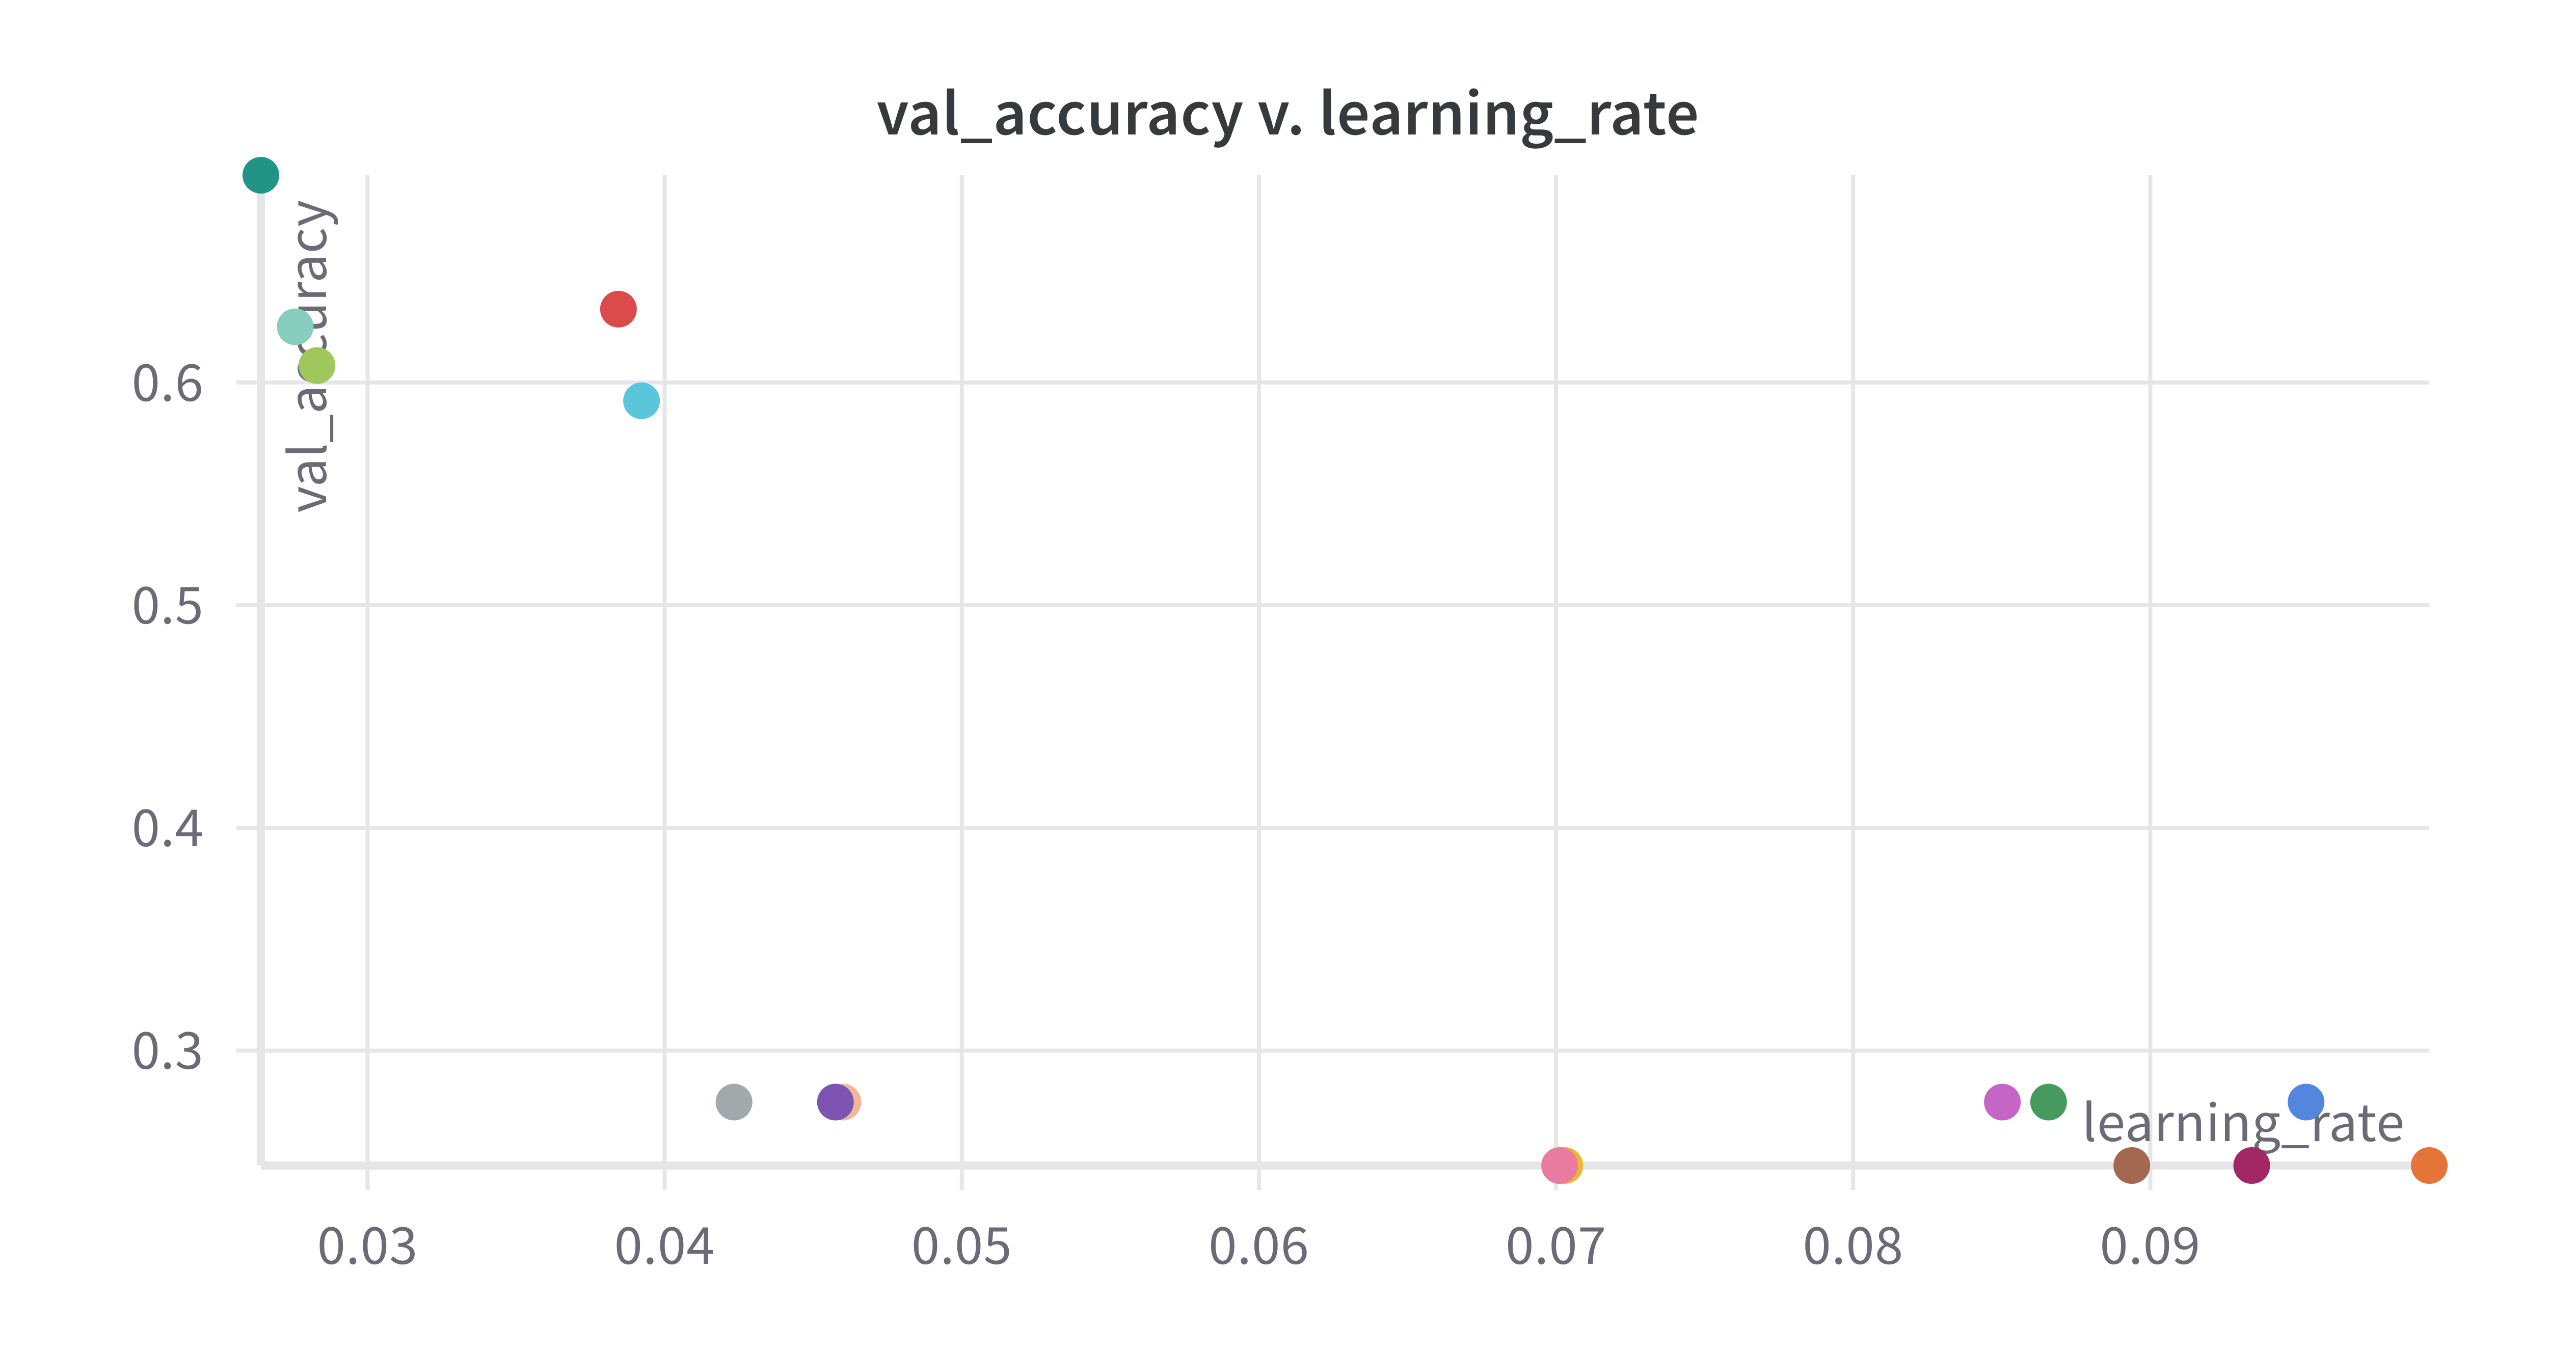

In [27]:
from IPython.display import Image

Image('images/lr_vs_val_acc_lstm_01.png')

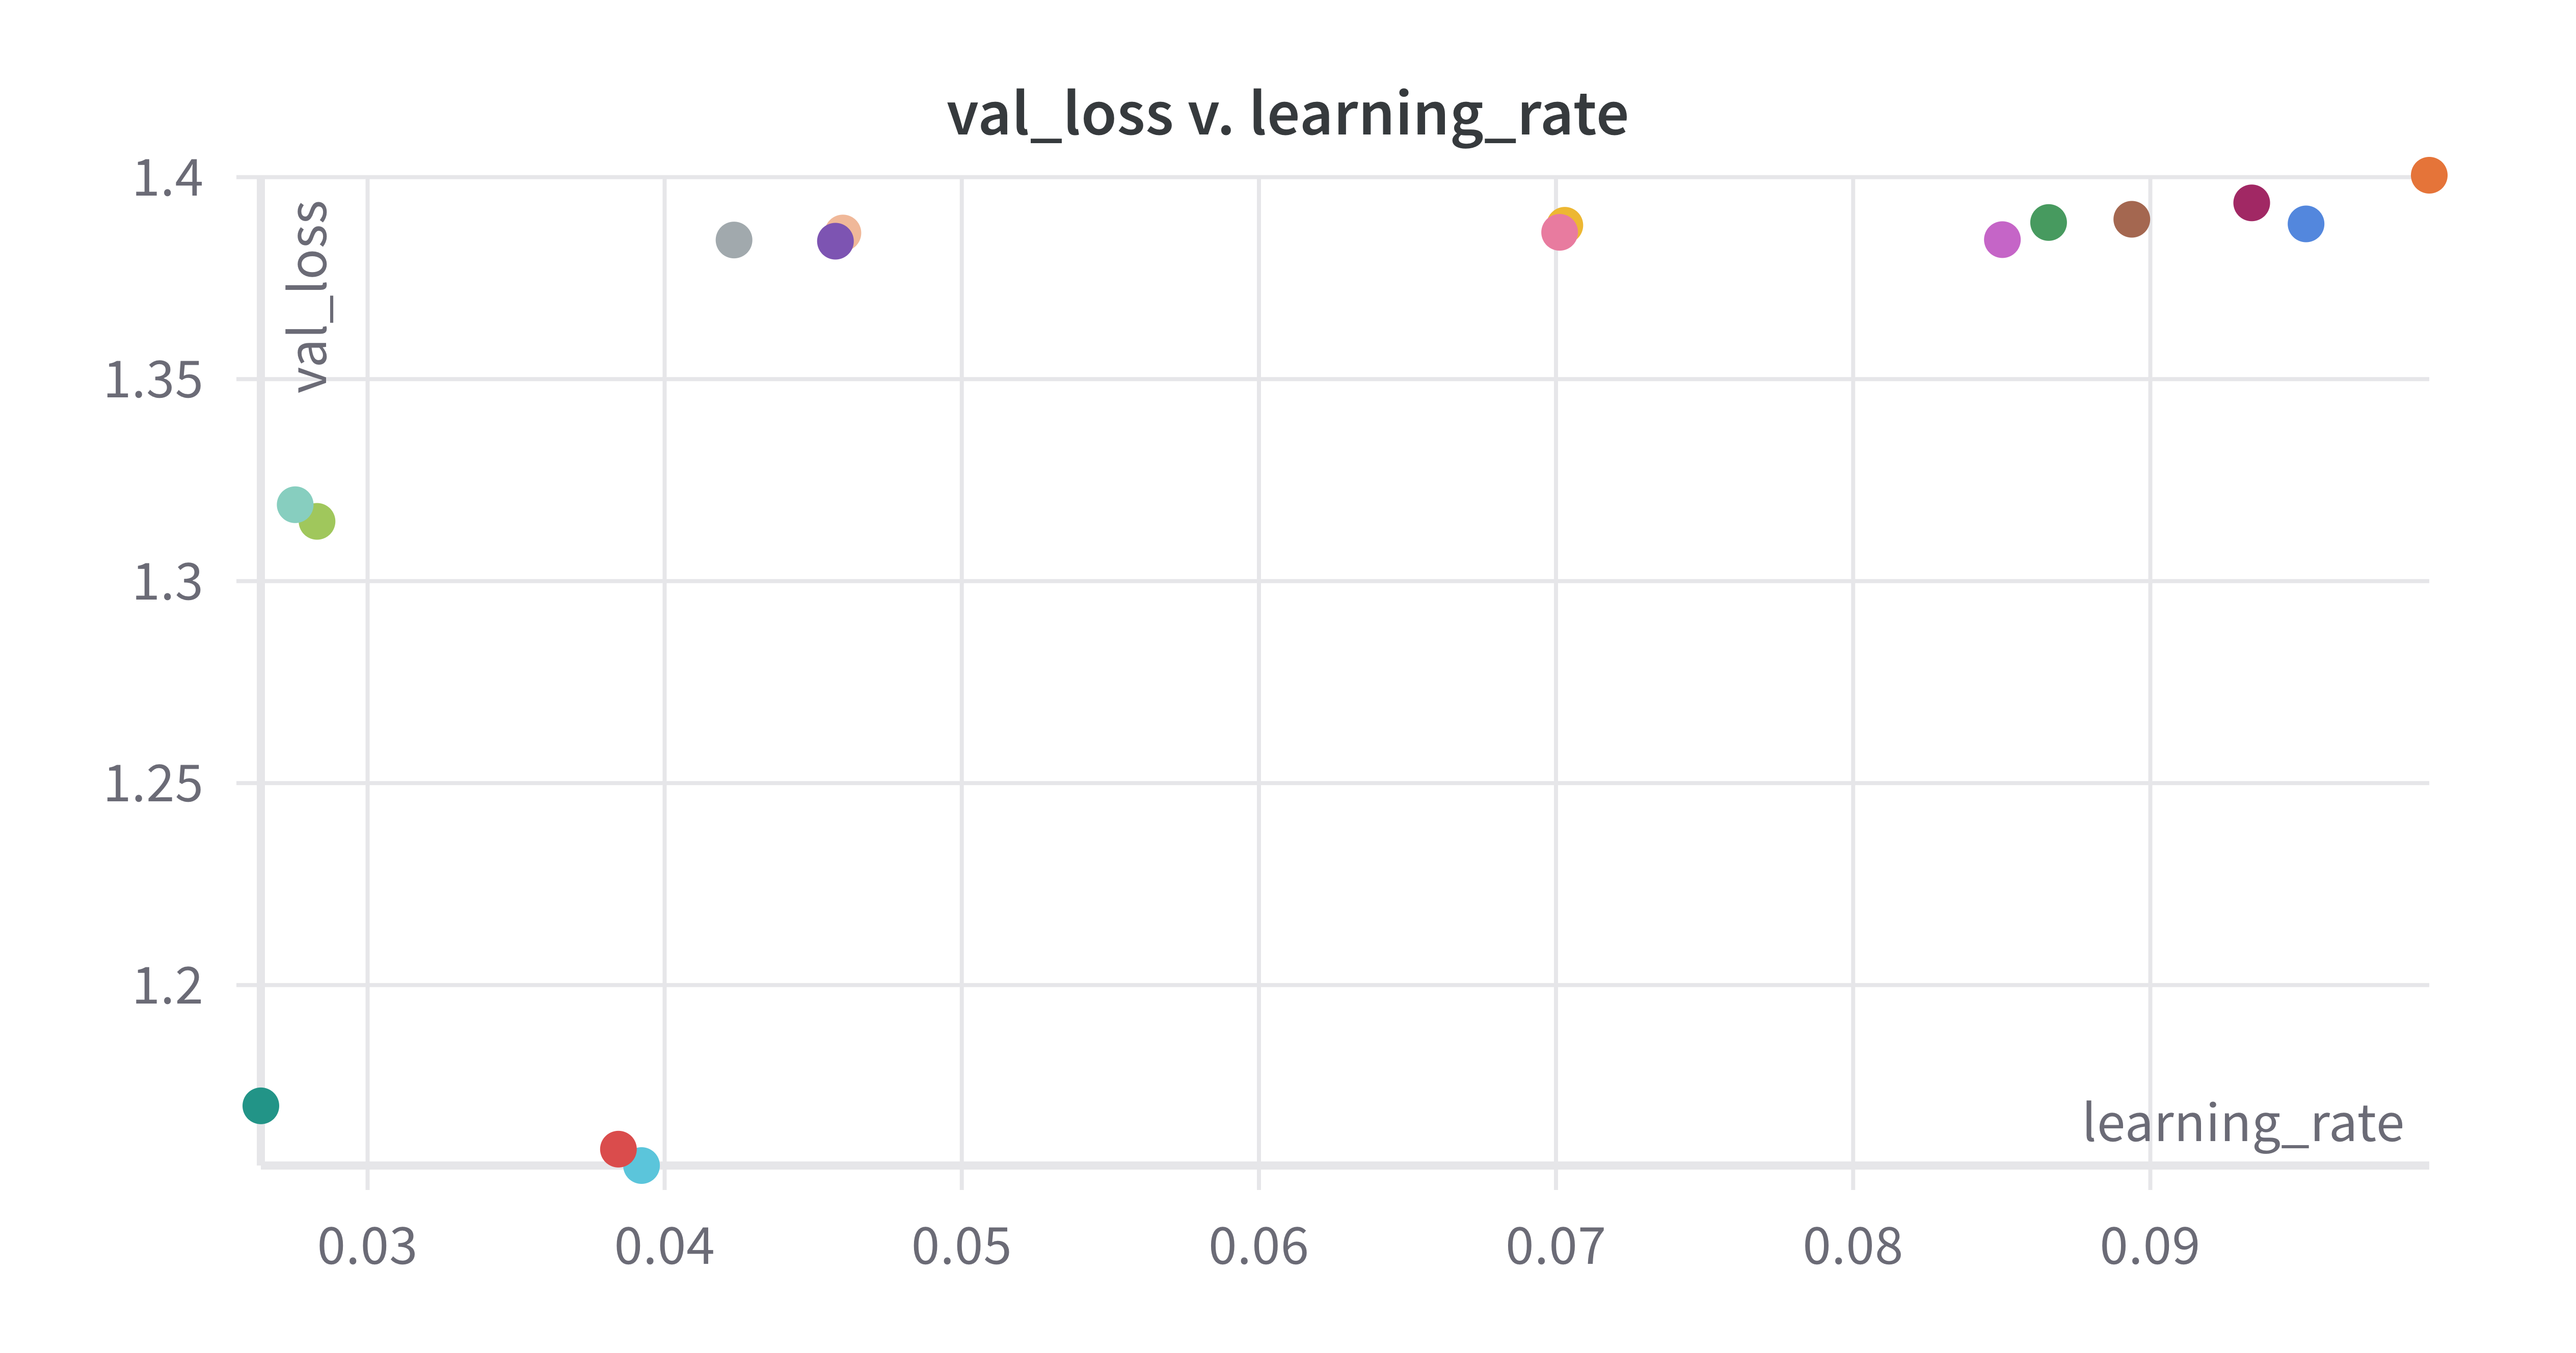

In [28]:
Image('images/lr_vs_val_loss_lstm_01.png')

Learning rate가 0.04 이하일 때 좋은 성적을 보인다. Learning rate의 범위를 좁혀서 다시 시도해보겠다.

In [29]:
sweep_config_lstm_02 = {
    "name": "sweep_DLthon_LSTM_02",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.04
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 20
            }
                    
        }
    }

sweep_id_lstm_02 = wandb.sweep(sweep_config_lstm_02,
                       entity = 'synkim1129',
                       project = 'DLthon')

# run the sweep
wandb.agent(sweep_id_lstm_02,
            function=train_lstm,
            count=10)

Create sweep with ID: qdjpsvxt
Sweep URL: https://wandb.ai/synkim1129/DLthon/sweeps/qdjpsvxt


wandb: Agent Starting Run: 6dw1flhe with config:
wandb: 	epoch: 14
wandb: 	learning_rate: 0.029021045480595524


Epoch 1/14
79/79 [==============================] - 7s 45ms/step - loss: 1.2701 - accuracy: 0.3916 - val_loss: 1.0416 - val_accuracy: 0.5032


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best)... Done. 0.0s


Epoch 2/14
79/79 [==============================] - 2s 30ms/step - loss: 0.9688 - accuracy: 0.5257 - val_loss: 1.0685 - val_accuracy: 0.5554
Epoch 3/14
79/79 [==============================] - 2s 28ms/step - loss: 0.7847 - accuracy: 0.6531 - val_loss: 1.0291 - val_accuracy: 0.5823


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best)... Done. 0.0s


Epoch 4/14
79/79 [==============================] - 2s 30ms/step - loss: 0.7074 - accuracy: 0.7239 - val_loss: 0.9978 - val_accuracy: 0.6266


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081548-6dw1flhe/files/model-best)... Done. 0.0s


Epoch 5/14
79/79 [==============================] - 2s 30ms/step - loss: 0.6067 - accuracy: 0.7765 - val_loss: 1.0478 - val_accuracy: 0.6123
Epoch 6/14
79/79 [==============================] - 2s 28ms/step - loss: 0.5171 - accuracy: 0.8212 - val_loss: 1.3087 - val_accuracy: 0.5997
Epoch 7/14
79/79 [==============================] - 2s 28ms/step - loss: 0.4397 - accuracy: 0.8465 - val_loss: 1.0496 - val_accuracy: 0.6092
Epoch 8/14
79/79 [==============================] - 2s 28ms/step - loss: 0.3988 - accuracy: 0.8588 - val_loss: 1.2323 - val_accuracy: 0.6203
Epoch 9/14
79/79 [==============================] - 2s 28ms/step - loss: 0.3842 - accuracy: 0.8706 - val_loss: 1.1881 - val_accuracy: 0.6377
Epoch 10/14
79/79 [==============================] - 2s 27ms/step - loss: 0.3685 - accuracy: 0.8841 - val_loss: 1.1034 - val_accuracy: 0.6630
Epoch 11/14
79/79 [==============================] - 2s 28ms/step - loss: 0.3506 - accuracy: 0.8857 - val_loss: 1.1332 - val_accuracy: 0.6377
Epoch 12/14

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▃▅▆▆▇▇███████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▆▄▄▃▂▂▁▁▁▁▁▁▂
val_accuracy,▁▃▄▆▆▅▆▆▇█▇▆▅▅
val_loss,▂▃▂▁▂█▂▆▅▃▄▇▆█
Test Accuracy Rate:,61.27
Test Error Rate:,38.73
accuracy,0.86116
best_epoch,3


wandb: Agent Starting Run: jtha1ueo with config:
wandb: 	epoch: 14
wandb: 	learning_rate: 0.014566182377775214


Epoch 1/14
79/79 [==============================] - 9s 66ms/step - loss: 1.1349 - accuracy: 0.4885 - val_loss: 1.1075 - val_accuracy: 0.6028


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best)... Done. 0.0s


Epoch 2/14
79/79 [==============================] - 2s 30ms/step - loss: 0.7242 - accuracy: 0.6970 - val_loss: 1.0026 - val_accuracy: 0.6361


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best)... Done. 0.0s


Epoch 3/14
79/79 [==============================] - 2s 30ms/step - loss: 0.5081 - accuracy: 0.8228 - val_loss: 0.8744 - val_accuracy: 0.6661


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081741-jtha1ueo/files/model-best)... Done. 0.0s


Epoch 4/14
79/79 [==============================] - 2s 30ms/step - loss: 0.3006 - accuracy: 0.9070 - val_loss: 0.9613 - val_accuracy: 0.7025
Epoch 5/14
79/79 [==============================] - 2s 28ms/step - loss: 0.1826 - accuracy: 0.9470 - val_loss: 1.1472 - val_accuracy: 0.7263
Epoch 6/14
79/79 [==============================] - 2s 28ms/step - loss: 0.1127 - accuracy: 0.9695 - val_loss: 1.0562 - val_accuracy: 0.7373
Epoch 7/14
79/79 [==============================] - 2s 28ms/step - loss: 0.0726 - accuracy: 0.9778 - val_loss: 1.2662 - val_accuracy: 0.7199
Epoch 8/14
79/79 [==============================] - 2s 28ms/step - loss: 0.0654 - accuracy: 0.9842 - val_loss: 1.2375 - val_accuracy: 0.7263
Epoch 9/14
79/79 [==============================] - 2s 28ms/step - loss: 0.0526 - accuracy: 0.9846 - val_loss: 1.2930 - val_accuracy: 0.7184
Epoch 10/14
79/79 [==============================] - 2s 28ms/step - loss: 0.0358 - accuracy: 0.9893 - val_loss: 1.3607 - val_accuracy: 0.7310
Epoch 11/14


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▆▇▇█████████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▇█▇▇▇█▇▇▇▇
val_loss,▃▂▁▂▃▃▄▄▅▅▇▆▅█
Test Accuracy Rate:,69.75
Test Error Rate:,30.25
accuracy,0.99486
best_epoch,2


wandb: Agent Starting Run: oxmer1w4 with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.004591885466648142


Epoch 1/5
79/79 [==============================] - 7s 44ms/step - loss: 1.0367 - accuracy: 0.5336 - val_loss: 0.6993 - val_accuracy: 0.7184


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081935-oxmer1w4/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081935-oxmer1w4/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081935-oxmer1w4/files/model-best)... Done. 0.0s


Epoch 2/5
79/79 [==============================] - 2s 30ms/step - loss: 0.3615 - accuracy: 0.8794 - val_loss: 0.6505 - val_accuracy: 0.7547


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081935-oxmer1w4/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081935-oxmer1w4/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_081935-oxmer1w4/files/model-best)... Done. 0.0s


Epoch 3/5
79/79 [==============================] - 2s 30ms/step - loss: 0.1486 - accuracy: 0.9577 - val_loss: 0.7640 - val_accuracy: 0.7674
Epoch 4/5
79/79 [==============================] - 2s 27ms/step - loss: 0.0746 - accuracy: 0.9810 - val_loss: 0.9020 - val_accuracy: 0.7642
Epoch 5/5
79/79 [==============================] - 2s 27ms/step - loss: 0.0379 - accuracy: 0.9901 - val_loss: 1.0097 - val_accuracy: 0.7722
25/25 - 0s - loss: 1.0329 - accuracy: 0.7759


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▆███
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,▂▁▃▆█
Test Accuracy Rate:,77.59
Test Error Rate:,22.41
accuracy,0.99011
best_epoch,1


wandb: Agent Starting Run: 4murgpbg with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.007792363558808801


Epoch 1/8
79/79 [==============================] - 7s 44ms/step - loss: 1.0542 - accuracy: 0.5174 - val_loss: 0.8069 - val_accuracy: 0.6693


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082046-4murgpbg/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082046-4murgpbg/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082046-4murgpbg/files/model-best)... Done. 0.0s


Epoch 2/8
79/79 [==============================] - 2s 30ms/step - loss: 0.5020 - accuracy: 0.8339 - val_loss: 0.6426 - val_accuracy: 0.7706


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082046-4murgpbg/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082046-4murgpbg/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082046-4murgpbg/files/model-best)... Done. 0.0s


Epoch 3/8
79/79 [==============================] - 2s 30ms/step - loss: 0.1816 - accuracy: 0.9478 - val_loss: 1.0516 - val_accuracy: 0.7104
Epoch 4/8
79/79 [==============================] - 2s 28ms/step - loss: 0.0955 - accuracy: 0.9735 - val_loss: 0.9765 - val_accuracy: 0.7373
Epoch 5/8
79/79 [==============================] - 2s 28ms/step - loss: 0.0715 - accuracy: 0.9798 - val_loss: 1.1236 - val_accuracy: 0.7373
Epoch 6/8
79/79 [==============================] - 2s 28ms/step - loss: 0.0584 - accuracy: 0.9834 - val_loss: 1.0091 - val_accuracy: 0.7690
Epoch 7/8
79/79 [==============================] - 2s 27ms/step - loss: 0.0256 - accuracy: 0.9921 - val_loss: 1.2607 - val_accuracy: 0.7389
Epoch 8/8
79/79 [==============================] - 2s 28ms/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 1.2293 - val_accuracy: 0.7642
25/25 - 0s - loss: 1.2719 - accuracy: 0.7456


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▆▇█████
epoch,▁▂▃▄▅▆▇█
loss,█▄▂▂▁▁▁▁
val_accuracy,▁█▄▆▆█▆█
val_loss,▃▁▆▅▆▅██
Test Accuracy Rate:,74.56
Test Error Rate:,25.44
accuracy,0.99525
best_epoch,1


wandb: Agent Starting Run: bq7jqjfs with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.016498493828495168


Epoch 1/5
79/79 [==============================] - 9s 44ms/step - loss: 1.1550 - accuracy: 0.4581 - val_loss: 0.9742 - val_accuracy: 0.5475


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best)... Done. 0.0s


Epoch 2/5
79/79 [==============================] - 2s 30ms/step - loss: 0.7347 - accuracy: 0.6899 - val_loss: 0.8748 - val_accuracy: 0.6915


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best)... Done. 0.0s


Epoch 3/5
79/79 [==============================] - 2s 30ms/step - loss: 0.4850 - accuracy: 0.8386 - val_loss: 1.0482 - val_accuracy: 0.6851
Epoch 4/5
79/79 [==============================] - 2s 28ms/step - loss: 0.3091 - accuracy: 0.9094 - val_loss: 1.1173 - val_accuracy: 0.6946
Epoch 5/5
79/79 [==============================] - 2s 28ms/step - loss: 0.1988 - accuracy: 0.9450 - val_loss: 0.8710 - val_accuracy: 0.7358


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082203-bq7jqjfs/files/model-best)... Done. 0.0s


25/25 - 0s - loss: 0.8799 - accuracy: 0.7241


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▆▆▆█
val_loss,▄▁▆█▁
Test Accuracy Rate:,72.41
Test Error Rate:,27.59
accuracy,0.94502
best_epoch,4


wandb: Agent Starting Run: xliynqz9 with config:
wandb: 	epoch: 20
wandb: 	learning_rate: 0.021958132690463553


Epoch 1/20
79/79 [==============================] - 9s 44ms/step - loss: 1.1082 - accuracy: 0.5170 - val_loss: 0.8562 - val_accuracy: 0.6725


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082335-xliynqz9/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082335-xliynqz9/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082335-xliynqz9/files/model-best)... Done. 0.0s


Epoch 2/20
79/79 [==============================] - 2s 30ms/step - loss: 0.7301 - accuracy: 0.7369 - val_loss: 0.8880 - val_accuracy: 0.6456
Epoch 3/20
79/79 [==============================] - 2s 28ms/step - loss: 0.4850 - accuracy: 0.8402 - val_loss: 0.8288 - val_accuracy: 0.7057


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082335-xliynqz9/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082335-xliynqz9/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082335-xliynqz9/files/model-best)... Done. 0.0s


Epoch 4/20
79/79 [==============================] - 2s 30ms/step - loss: 0.3273 - accuracy: 0.9039 - val_loss: 1.0224 - val_accuracy: 0.6630
Epoch 5/20
79/79 [==============================] - 2s 28ms/step - loss: 0.2366 - accuracy: 0.9331 - val_loss: 0.8948 - val_accuracy: 0.7025
Epoch 6/20
79/79 [==============================] - 2s 28ms/step - loss: 0.1524 - accuracy: 0.9525 - val_loss: 0.9778 - val_accuracy: 0.7199
Epoch 7/20
79/79 [==============================] - 2s 28ms/step - loss: 0.1233 - accuracy: 0.9676 - val_loss: 0.9895 - val_accuracy: 0.7247
Epoch 8/20
79/79 [==============================] - 2s 28ms/step - loss: 0.1372 - accuracy: 0.9612 - val_loss: 0.9396 - val_accuracy: 0.7342
Epoch 9/20
79/79 [==============================] - 2s 28ms/step - loss: 0.1052 - accuracy: 0.9719 - val_loss: 1.1883 - val_accuracy: 0.7231
Epoch 10/20
79/79 [==============================] - 2s 28ms/step - loss: 0.0923 - accuracy: 0.9707 - val_loss: 1.1809 - val_accuracy: 0.7025
Epoch 11/20


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▆▇▇████████▇██████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁
val_accuracy,▃▁▆▂▅▇▇█▇▅▇▅▃▆▇▇▅▅▄▄
val_loss,▁▂▁▃▂▃▃▂▅▅▇▇▆▄▃▄▅▅▅█
Test Accuracy Rate:,68.86
Test Error Rate:,31.14
accuracy,0.96479
best_epoch,2


wandb: Agent Starting Run: fslsd365 with config:
wandb: 	epoch: 20
wandb: 	learning_rate: 0.03600624208113921


Epoch 1/20
79/79 [==============================] - 7s 45ms/step - loss: 1.4339 - accuracy: 0.2445 - val_loss: 1.3840 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082517-fslsd365/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082517-fslsd365/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082517-fslsd365/files/model-best)... Done. 0.0s


Epoch 2/20
79/79 [==============================] - 2s 30ms/step - loss: 1.3853 - accuracy: 0.2634 - val_loss: 1.3860 - val_accuracy: 0.2769
Epoch 3/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3868 - accuracy: 0.2666 - val_loss: 1.3862 - val_accuracy: 0.2769
Epoch 4/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3864 - accuracy: 0.2631 - val_loss: 1.3864 - val_accuracy: 0.2484
Epoch 5/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3866 - accuracy: 0.2559 - val_loss: 1.3861 - val_accuracy: 0.2769
Epoch 6/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3865 - accuracy: 0.2741 - val_loss: 1.3869 - val_accuracy: 0.2769
Epoch 7/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3872 - accuracy: 0.2686 - val_loss: 1.3838 - val_accuracy: 0.2769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082517-fslsd365/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082517-fslsd365/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082517-fslsd365/files/model-best)... Done. 0.0s


Epoch 8/20
79/79 [==============================] - 2s 30ms/step - loss: 1.3879 - accuracy: 0.2650 - val_loss: 1.3880 - val_accuracy: 0.2484
Epoch 9/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3860 - accuracy: 0.2714 - val_loss: 1.3888 - val_accuracy: 0.2484
Epoch 10/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3863 - accuracy: 0.2670 - val_loss: 1.3892 - val_accuracy: 0.2769
Epoch 11/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3862 - accuracy: 0.2690 - val_loss: 1.3859 - val_accuracy: 0.2484
Epoch 12/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3875 - accuracy: 0.2607 - val_loss: 1.3853 - val_accuracy: 0.2769
Epoch 13/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3856 - accuracy: 0.2682 - val_loss: 1.3875 - val_accuracy: 0.2769
Epoch 14/20
79/79 [==============================] - 2s 28ms/step - loss: 1.3875 - accuracy: 0.2666 - val_loss: 1.3878 - val_accuracy: 0.2484
Epoch 15

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▅▆▅▄█▇▆▇▆▇▅▇▆▅▅▇▄▇▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,███▁███▁▁█▁██▁████▁▁
val_loss,▁▄▄▄▄▅▁▆▇█▄▃▆▆▂▁▆▁▂▆
Test Accuracy Rate:,24.81
Test Error Rate:,75.19
accuracy,0.26622
best_epoch,6


wandb: Agent Starting Run: 3wcqv52t with config:
wandb: 	epoch: 12
wandb: 	learning_rate: 0.020414411105350944


Epoch 1/12
79/79 [==============================] - 9s 44ms/step - loss: 1.2300 - accuracy: 0.4142 - val_loss: 1.0035 - val_accuracy: 0.5712


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best)... Done. 0.0s


Epoch 2/12
79/79 [==============================] - 2s 30ms/step - loss: 0.8438 - accuracy: 0.6210 - val_loss: 0.9812 - val_accuracy: 0.6092


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best)... Done. 0.0s


Epoch 3/12
79/79 [==============================] - 2s 30ms/step - loss: 0.6430 - accuracy: 0.7215 - val_loss: 0.9765 - val_accuracy: 0.6361


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best)... Done. 0.0s


Epoch 4/12
79/79 [==============================] - 2s 31ms/step - loss: 0.4562 - accuracy: 0.8200 - val_loss: 0.9302 - val_accuracy: 0.6551


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082658-3wcqv52t/files/model-best)... Done. 0.0s


Epoch 5/12
79/79 [==============================] - 2s 30ms/step - loss: 0.3286 - accuracy: 0.8821 - val_loss: 1.2959 - val_accuracy: 0.6630
Epoch 6/12
79/79 [==============================] - 2s 28ms/step - loss: 0.2437 - accuracy: 0.9185 - val_loss: 1.1009 - val_accuracy: 0.7057
Epoch 7/12
79/79 [==============================] - 2s 28ms/step - loss: 0.1992 - accuracy: 0.9434 - val_loss: 1.0769 - val_accuracy: 0.6725
Epoch 8/12
79/79 [==============================] - 2s 28ms/step - loss: 0.1478 - accuracy: 0.9561 - val_loss: 1.2553 - val_accuracy: 0.6867
Epoch 9/12
79/79 [==============================] - 2s 28ms/step - loss: 0.1442 - accuracy: 0.9585 - val_loss: 1.2276 - val_accuracy: 0.6994
Epoch 10/12
79/79 [==============================] - 2s 28ms/step - loss: 0.0896 - accuracy: 0.9743 - val_loss: 1.4991 - val_accuracy: 0.6851
Epoch 11/12
79/79 [==============================] - 2s 28ms/step - loss: 0.0705 - accuracy: 0.9782 - val_loss: 1.2977 - val_accuracy: 0.7168
Epoch 12/12

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▅▆▇▇██████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▆▄▃▃▂▂▁▁▁▁▁
val_accuracy,▁▃▄▅▅▇▆▇▇▆█▇
val_loss,▂▂▂▁▅▃▃▅▅█▆▆
Test Accuracy Rate:,67.47
Test Error Rate:,32.53
accuracy,0.97824
best_epoch,3


wandb: Agent Starting Run: r9xhrt59 with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.02958531722218809


Epoch 1/9
79/79 [==============================] - 9s 44ms/step - loss: 1.2571 - accuracy: 0.4078 - val_loss: 1.0170 - val_accuracy: 0.5332


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best)... Done. 0.0s


Epoch 2/9
79/79 [==============================] - 2s 31ms/step - loss: 0.8508 - accuracy: 0.6369 - val_loss: 0.9249 - val_accuracy: 0.5902


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best)... Done. 0.0s


Epoch 3/9
79/79 [==============================] - 2s 30ms/step - loss: 0.6151 - accuracy: 0.7619 - val_loss: 1.0112 - val_accuracy: 0.6377
Epoch 4/9
79/79 [==============================] - 2s 28ms/step - loss: 0.4452 - accuracy: 0.8406 - val_loss: 0.8807 - val_accuracy: 0.7041


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_082905-r9xhrt59/files/model-best)... Done. 0.0s


Epoch 5/9
79/79 [==============================] - 2s 30ms/step - loss: 0.3061 - accuracy: 0.8987 - val_loss: 1.3738 - val_accuracy: 0.6994
Epoch 6/9
79/79 [==============================] - 2s 29ms/step - loss: 0.2409 - accuracy: 0.9256 - val_loss: 1.3397 - val_accuracy: 0.6693
Epoch 7/9
79/79 [==============================] - 2s 28ms/step - loss: 0.2103 - accuracy: 0.9351 - val_loss: 1.2788 - val_accuracy: 0.6661
Epoch 8/9
79/79 [==============================] - 2s 28ms/step - loss: 0.1957 - accuracy: 0.9391 - val_loss: 1.2918 - val_accuracy: 0.6946
Epoch 9/9
79/79 [==============================] - 2s 29ms/step - loss: 0.2144 - accuracy: 0.9300 - val_loss: 1.1541 - val_accuracy: 0.6693
25/25 - 0s - loss: 1.2381 - accuracy: 0.6671


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▆▇▇████
epoch,▁▂▃▄▅▅▆▇█
loss,█▅▄▃▂▁▁▁▁
val_accuracy,▁▃▅██▇▆█▇
val_loss,▃▂▃▁██▇▇▅
Test Accuracy Rate:,66.71
Test Error Rate:,33.29
accuracy,0.92998
best_epoch,3


wandb: Agent Starting Run: h812tnqj with config:
wandb: 	epoch: 18
wandb: 	learning_rate: 0.004013291914364892


Epoch 1/18
79/79 [==============================] - 9s 44ms/step - loss: 0.9752 - accuracy: 0.5696 - val_loss: 0.6596 - val_accuracy: 0.7769


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_083042-h812tnqj/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_083042-h812tnqj/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/aiffel_DLthon/wandb/run-20231120_083042-h812tnqj/files/model-best)... Done. 0.0s


Epoch 2/18
79/79 [==============================] - 2s 30ms/step - loss: 0.3965 - accuracy: 0.8667 - val_loss: 0.6810 - val_accuracy: 0.7706
Epoch 3/18
79/79 [==============================] - 2s 28ms/step - loss: 0.1326 - accuracy: 0.9616 - val_loss: 0.8944 - val_accuracy: 0.7484
Epoch 4/18
79/79 [==============================] - 2s 28ms/step - loss: 0.0681 - accuracy: 0.9798 - val_loss: 0.9333 - val_accuracy: 0.7579
Epoch 5/18
79/79 [==============================] - 2s 27ms/step - loss: 0.0261 - accuracy: 0.9917 - val_loss: 1.2279 - val_accuracy: 0.7658
Epoch 6/18
79/79 [==============================] - 2s 27ms/step - loss: 0.0158 - accuracy: 0.9968 - val_loss: 1.2757 - val_accuracy: 0.7579
Epoch 7/18
79/79 [==============================] - 2s 28ms/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 1.3180 - val_accuracy: 0.7500
Epoch 8/18
79/79 [==============================] - 2s 28ms/step - loss: 0.0280 - accuracy: 0.9921 - val_loss: 1.3287 - val_accuracy: 0.7278
Epoch 9/18
79

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▆▇███████████████
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_accuracy,█▇▄▆▇▆▄▂▄▂▃▁▄▆▆▆▆▆
val_loss,▁▁▃▃▅▅▅▅▅▅▆▇▅▆▇▇██
Test Accuracy Rate:,76.84
Test Error Rate:,23.16
accuracy,1.0
best_epoch,0


In [ ]:
sweep_config_tr = {
    "name": "sweep_DLthon_Transformer_01",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 20
            }
                    
        }
    }

In [26]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dropout, LayerNormalization, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def train_tr():
    default_config = {
        "vocab_size" : 10000,
        "embedding_dim" : 64,
        "max_seq_len" : 200,
        "num_heads" : 4,
        "ff_dim" : 64,
        "units_dense" : 64,
        "class_num" : 4,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 10,
        "batch_size" : 32
    }
    
    wandb.init(config = default_config)
    config = wandb.config


    # 모델의 입력 정의
    sequence_input = Input(shape=(config.max_seq_length,), dtype='int32')

    # 임베딩 레이어
    embedded_sequences = Embedding(config.vocab_size, config.embedding_dim)(sequence_input)

    # 트랜스포머 블록
    # 멀티 헤드 어텐션
    attention_output = MultiHeadAttention(num_heads=config.num_heads, key_dim=config.embedding_dim)(embedded_sequences, embedded_sequences)
    attention_output = Dropout(0.1)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(embedded_sequences + attention_output)

    # 피드포워드 네트워크
    ffn_output = Dense(config.ff_dim, activation='relu')(attention_output)
    ffn_output = Dropout(0.1)(ffn_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    # 글로벌 평균 풀링을 사용하여 시퀀스 차원을 축소
    pooled_output = GlobalAveragePooling1D()(sequence_output)

    # Dense 레이어
    x = Dense(config.units_dense, activation='relu')(pooled_output)

    # 출력 레이어: 4개의 클래스에 대한 예측을 출력
    predictions = Dense(config.class_nums, activation='softmax')(x)

    # 최종 모델 생성
    model = Model(sequence_input, predictions)

    if config.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate = config.learning_rate)

    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(x_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (x_val, y_val),
              callbacks = [WandbCallback()])
    
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})


In [ ]:


sweep_id_tr = wandb.sweep(sweep_config_tr,
                       entity = 'synkim1129',
                       project = 'DLthon')

# run the sweep
wandb.agent(sweep_id_tr,
            function=train_tr,
            count=16)